In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, WeightedRandomSampler, Dataset
from torchvision import transforms, models
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
from tqdm import tqdm
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torchvision.models import EfficientNet_V2_S_Weights
from torchvision.models import resnet18


In [2]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
import os

class FERPlusImageFolderDataModule:
    def __init__(self, root_dir, batch_size=64):
        self.train_dir = os.path.join(root_dir, "train")
        self.test_dir = os.path.join(root_dir, "test")
        self.batch_size = batch_size
        

        
        self.train_transform = transforms.Compose([
            transforms.Resize((48, 48)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(10),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

        
        self.eval_transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),  # Ensure grayscale
            transforms.Resize((48, 48)),                  # Standard FER size
            transforms.ToTensor(),                        # Convert to [0,1] tensor
            transforms.Normalize(mean=[0.5], std=[0.5])   # Normalize grayscale
        ])

    def setup(self):
        self.train_dataset = ImageFolder(self.train_dir, transform=self.train_transform)
        self.test_dataset = ImageFolder(self.test_dir, transform=self.eval_transform)


        print("Train class distribution:")
        for cls in self.train_dataset.classes:
            count = len([x for x in self.train_dataset.samples if x[1] == self.train_dataset.class_to_idx[cls]])
        print(f"{cls}: {count}")

        
        # Split test into val + test manually (optional)
        val_size = int(0.5 * len(self.test_dataset))
        test_size = len(self.test_dataset) - val_size
        self.val_dataset, self.test_dataset = torch.utils.data.random_split(
            self.test_dataset, [val_size, test_size], generator=torch.Generator().manual_seed(42)
        )
    def train_dataloader(self):
        return DataLoader(self.train_dataset,batch_size=self.batch_size,shuffle=True,num_workers=4)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2)


In [3]:
class EmotionDetectorResNet18(nn.Module):
    def __init__(self, num_classes=8):
        super(EmotionDetectorResNet18, self).__init__()
        self.model = resnet18(weights='IMAGENET1K_V1')  # Pretrained weights

        # Modify for grayscale input
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Replace final classifier
        self.model.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [4]:
class EmotionDetectorMobileNetV2(nn.Module):
    def __init__(self, num_classes=8):
        super(EmotionDetectorMobileNetV2, self).__init__()
        self.model = models.mobilenet_v2(pretrained=True)  # Using MobileNetV2 as base model

        self.model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
        # Modify the classifier to match our problem
        self.model.classifier[1] = nn.Sequential(
            nn.Dropout(p=0.7),  # Increased dropout to 50%
            nn.Linear(self.model.classifier[1].in_features, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [5]:
from torchvision.models import efficientnet_v2_s

class EmotionDetectorEffNet(nn.Module):
    def __init__(self, num_classes=8):
        super(EmotionDetectorEffNet, self).__init__()
        self.model = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT)  # Use pre-trained weights
        self.model.features[0][0] = nn.Conv2d(1, 24, kernel_size=3, stride=2, padding=1, bias=False)
        self.model.classifier[1] = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(self.model.classifier[1].in_features, num_classes)
        )

    def forward(self, x):
        return self.model(x)


In [6]:
import torch.nn as nn
import torch
from torchvision import models

class EmotionDetectorVGGFace(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionDetectorVGGFace, self).__init__()
        # Use VGG16 as base for VGG-Face-like architecture
        self.model = models.vgg16(pretrained=True)  # You can replace this with custom VGG-Face weights

        # Change input conv layer to accept grayscale images
        self.model.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)

        # Replace classifier to output emotions
        self.model.classifier = nn.Sequential(
            nn.Linear(25088, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        return self.model(x)


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import *
from sklearn.metrics import precision_recall_fscore_support
from tqdm import tqdm


def train_model(model, train_loader, val_loader, num_epochs, device, save_path="best_model.pth", lr=0.01, use_tqdm=True, train_dataset=None, early_stop_patience=10):
    model = model.to(device)
    labels = torch.tensor([s[1] for s in train_dataset.samples], dtype=torch.long)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0)
    warmup_epochs = 5  # You can adjust this
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=7, factor=0.5)
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'val_precision': [], 'val_recall': [], 'val_f1': []
    }

    best_f1 = 0.0
    best_val_acc = 0.0
    best_val_loss = float('inf')  # Initialize best_val_loss with infinity
    best_model_path = save_path
    no_improve_epochs = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]") if use_tqdm else train_loader
        for inputs, labels in train_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            train_bar.set_postfix(loss=running_loss / total, acc=100. * correct / total)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = 100. * correct / total

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_preds = []
        all_labels = []

        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]") if use_tqdm else val_loader
        with torch.no_grad():
            for inputs, labels in val_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                val_bar.set_postfix(loss=val_loss / val_total, acc=100. * val_correct / val_total)

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = 100. * val_correct / val_total

        precision, recall, f1, _ = precision_recall_fscore_support(
            all_labels, all_preds, average='weighted', zero_division=0
        )

        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        history['val_precision'].append(precision)
        history['val_recall'].append(recall)
        history['val_f1'].append(f1)

        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%")
        print(f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")
        print(f"Val Precision: {precision:.4f}, Val Recall: {recall:.4f}, Val F1: {f1:.4f}")

        

        # Save best model based on both accuracy and loss
        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved with Val F1: {best_f1:.4f} at {best_model_path}")
            no_improve_epochs = 0  # reset early stopping counter
        
        # else:
        #     no_improve_epochs += 1
        #     if no_improve_epochs >= early_stop_patience:
        #         print(f"Early stopping triggered after {early_stop_patience} epochs without improvement.")
        #         break

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scheduler.step(epoch_val_loss)

    final_model_path = save_path.replace(".pth", "_final.pth")
    torch.save(model.state_dict(), final_model_path)
    print(f"Final model saved at {final_model_path}")

    return history



def test_model(model, test_loader, device, test_dataset=None):
    """
    Test function to evaluate the model on a test dataset.

    Args:
        model: Trained CNN model
        test_loader: DataLoader for test data
        device: Device to test on ('cuda' or 'cpu')
        test_dataset: Optional: dataset for calculating class weights (if needed)

    Returns:
        test_loss: Average test loss
        test_acc: Test accuracy
        precision: Weighted precision
        recall: Weighted recall
        f1: Weighted F1-score
    """
    print("Testing")
    model.load_state_dict(torch.load("/kaggle/working/best_emotion_model.pth"))

    model = model.to(device)
    model.eval()

    labels = torch.tensor([s[1] for s in test_dataset.dataset.samples], dtype=torch.long)
    criterion = nn.CrossEntropyLoss()
    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    test_bar = tqdm(test_loader, desc="Testing")  # Add a progress bar for testing
    with torch.no_grad():
        for inputs, labels in test_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            test_bar.set_postfix(loss=test_loss / total, acc=100. * correct / total)

    test_loss = test_loss / len(test_loader.dataset)
    test_acc = 100. * correct / total

    # Calculate precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted', zero_division=0
    )

    print(f"\nTest Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    print(f"Test Precision: {precision:.4f}, Test Recall: {recall:.4f}, Test F1: {f1:.4f}")

    return test_loss, test_acc, precision, recall, f1, all_preds, all_labels


In [8]:
# class WeightedCrossEntropyLoss(nn.Module):
#     def __init__(self, labels, device, num_classes=8):
#         super().__init__()
#         self.device = device
#         self.num_classes = num_classes
#         self.weights = self.__compute_weights(labels).to(device)
#         self.loss = nn.CrossEntropyLoss(weight=self.weights)

#     def __compute_weights(self, labels):
#         class_counts = torch.bincount(labels, minlength=self.num_classes)
#         total_samples = len(labels)
#         weights = total_samples / (self.num_classes * class_counts.float())
#         return weights

#     def forward(self, outputs, targets):
#         return self.loss(outputs, targets)


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def plot_loss_curve(train_loss, val_loss):
    """    
    Plots the training and validation loss curves.
    
    Parameters:       
    - train_loss: List of training loss values per epoch
    - val_loss: List of validation loss values per epoch
    """
    #Loss curve , still don't know list names 
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Loss per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_accuracy_curve(train_acc, val_acc):
    """
    Plots training and validation accuracy per epoch.
    
    Args:
        train_acc (list): Training accuracy values
        val_acc (list): Validation accuracy values
    """
    plt.figure(figsize=(10, 5))
    plt.plot(train_acc, label='Train Accuracy', marker='o')
    plt.plot(val_acc, label='Validation Accuracy', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Model Accuracy per Epoch')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))



Train class distribution:
6: 6187


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 187MB/s]
Epoch 1/80 [Val]: 100%|██████████| 57/57 [00:05<00:00,  9.96it/s, acc=69.8, loss=0.837]



Epoch 1/80
Train Loss: 1.3746, Train Acc: 48.01%
Val Loss: 0.8366, Val Acc: 69.82%
Val Precision: 0.6929, Val Recall: 0.6982, Val F1: 0.6837
Best model saved with Val F1: 0.6837 at /kaggle/working/best_emotion_model.pth


Epoch 2/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 23.72it/s, acc=73, loss=0.739]



Epoch 2/80
Train Loss: 0.8607, Train Acc: 69.21%
Val Loss: 0.7389, Val Acc: 72.96%
Val Precision: 0.7442, Val Recall: 0.7296, Val F1: 0.7298
Best model saved with Val F1: 0.7298 at /kaggle/working/best_emotion_model.pth


Epoch 3/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 24.76it/s, acc=78.6, loss=0.613]



Epoch 3/80
Train Loss: 0.7239, Train Acc: 74.03%
Val Loss: 0.6135, Val Acc: 78.56%
Val Precision: 0.7879, Val Recall: 0.7856, Val F1: 0.7790
Best model saved with Val F1: 0.7790 at /kaggle/working/best_emotion_model.pth


Epoch 4/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 24.66it/s, acc=78.5, loss=0.593]



Epoch 4/80
Train Loss: 0.6276, Train Acc: 77.37%
Val Loss: 0.5925, Val Acc: 78.50%
Val Precision: 0.7951, Val Recall: 0.7850, Val F1: 0.7829
Best model saved with Val F1: 0.7829 at /kaggle/working/best_emotion_model.pth


Epoch 5/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 25.20it/s, acc=80.4, loss=0.569]



Epoch 5/80
Train Loss: 0.5672, Train Acc: 79.69%
Val Loss: 0.5688, Val Acc: 80.37%
Val Precision: 0.8087, Val Recall: 0.8037, Val F1: 0.8030
Best model saved with Val F1: 0.8030 at /kaggle/working/best_emotion_model.pth


Epoch 6/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 23.25it/s, acc=80.8, loss=0.551]



Epoch 6/80
Train Loss: 0.5088, Train Acc: 81.48%
Val Loss: 0.5509, Val Acc: 80.84%
Val Precision: 0.8122, Val Recall: 0.8084, Val F1: 0.8089
Best model saved with Val F1: 0.8089 at /kaggle/working/best_emotion_model.pth


Epoch 7/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 22.74it/s, acc=80.6, loss=0.558]



Epoch 7/80
Train Loss: 0.4594, Train Acc: 83.63%
Val Loss: 0.5584, Val Acc: 80.57%
Val Precision: 0.8072, Val Recall: 0.8057, Val F1: 0.8035


Epoch 8/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 23.17it/s, acc=80.1, loss=0.647]



Epoch 8/80
Train Loss: 0.4139, Train Acc: 85.32%
Val Loss: 0.6467, Val Acc: 80.13%
Val Precision: 0.8058, Val Recall: 0.8013, Val F1: 0.7976


Epoch 9/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 23.36it/s, acc=80.6, loss=0.586]



Epoch 9/80
Train Loss: 0.3681, Train Acc: 86.87%
Val Loss: 0.5862, Val Acc: 80.57%
Val Precision: 0.8115, Val Recall: 0.8057, Val F1: 0.8050


Epoch 10/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 21.81it/s, acc=80.8, loss=0.607]



Epoch 10/80
Train Loss: 0.3384, Train Acc: 88.15%
Val Loss: 0.6073, Val Acc: 80.79%
Val Precision: 0.8128, Val Recall: 0.8079, Val F1: 0.8087


Epoch 11/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 20.13it/s, acc=80.4, loss=0.678]



Epoch 11/80
Train Loss: 0.2981, Train Acc: 89.69%
Val Loss: 0.6783, Val Acc: 80.43%
Val Precision: 0.8082, Val Recall: 0.8043, Val F1: 0.7980


Epoch 12/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 23.46it/s, acc=80.1, loss=0.696]



Epoch 12/80
Train Loss: 0.2693, Train Acc: 90.58%
Val Loss: 0.6960, Val Acc: 80.13%
Val Precision: 0.8032, Val Recall: 0.8013, Val F1: 0.7963


Epoch 13/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 23.44it/s, acc=79.7, loss=0.687]



Epoch 13/80
Train Loss: 0.2559, Train Acc: 91.20%
Val Loss: 0.6873, Val Acc: 79.71%
Val Precision: 0.8027, Val Recall: 0.7971, Val F1: 0.7940


Epoch 14/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 22.49it/s, acc=81.7, loss=0.677]



Epoch 14/80
Train Loss: 0.2290, Train Acc: 92.04%
Val Loss: 0.6774, Val Acc: 81.67%
Val Precision: 0.8175, Val Recall: 0.8167, Val F1: 0.8128
Best model saved with Val F1: 0.8128 at /kaggle/working/best_emotion_model.pth


Epoch 15/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 22.83it/s, acc=82.3, loss=0.758]



Epoch 15/80
Train Loss: 0.1403, Train Acc: 95.17%
Val Loss: 0.7579, Val Acc: 82.30%
Val Precision: 0.8221, Val Recall: 0.8230, Val F1: 0.8194
Best model saved with Val F1: 0.8194 at /kaggle/working/best_emotion_model.pth


Epoch 16/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 23.58it/s, acc=82.9, loss=0.699]



Epoch 16/80
Train Loss: 0.1248, Train Acc: 95.65%
Val Loss: 0.6988, Val Acc: 82.94%
Val Precision: 0.8272, Val Recall: 0.8294, Val F1: 0.8272
Best model saved with Val F1: 0.8272 at /kaggle/working/best_emotion_model.pth


Epoch 17/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 24.30it/s, acc=81.5, loss=0.846]



Epoch 17/80
Train Loss: 0.1040, Train Acc: 96.42%
Val Loss: 0.8461, Val Acc: 81.48%
Val Precision: 0.8153, Val Recall: 0.8148, Val F1: 0.8114


Epoch 18/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 22.58it/s, acc=82, loss=0.856]



Epoch 18/80
Train Loss: 0.0973, Train Acc: 96.65%
Val Loss: 0.8564, Val Acc: 82.00%
Val Precision: 0.8206, Val Recall: 0.8200, Val F1: 0.8187


Epoch 19/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 22.69it/s, acc=82, loss=0.855]



Epoch 19/80
Train Loss: 0.0916, Train Acc: 96.91%
Val Loss: 0.8546, Val Acc: 82.03%
Val Precision: 0.8207, Val Recall: 0.8203, Val F1: 0.8200


Epoch 20/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 22.91it/s, acc=81.9, loss=0.898]



Epoch 20/80
Train Loss: 0.0870, Train Acc: 97.03%
Val Loss: 0.8977, Val Acc: 81.95%
Val Precision: 0.8254, Val Recall: 0.8195, Val F1: 0.8183


Epoch 21/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 22.06it/s, acc=81.9, loss=0.842]



Epoch 21/80
Train Loss: 0.0781, Train Acc: 97.33%
Val Loss: 0.8417, Val Acc: 81.92%
Val Precision: 0.8200, Val Recall: 0.8192, Val F1: 0.8182


Epoch 22/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 23.80it/s, acc=82.3, loss=0.917]



Epoch 22/80
Train Loss: 0.0731, Train Acc: 97.61%
Val Loss: 0.9171, Val Acc: 82.30%
Val Precision: 0.8228, Val Recall: 0.8230, Val F1: 0.8223


Epoch 23/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 25.27it/s, acc=82.2, loss=1.05]



Epoch 23/80
Train Loss: 0.0457, Train Acc: 98.53%
Val Loss: 1.0541, Val Acc: 82.22%
Val Precision: 0.8232, Val Recall: 0.8222, Val F1: 0.8194


Epoch 24/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 24.98it/s, acc=82.9, loss=1.02]



Epoch 24/80
Train Loss: 0.0372, Train Acc: 98.78%
Val Loss: 1.0165, Val Acc: 82.86%
Val Precision: 0.8296, Val Recall: 0.8286, Val F1: 0.8263


Epoch 25/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 24.78it/s, acc=82.4, loss=1.08]



Epoch 25/80
Train Loss: 0.0355, Train Acc: 98.80%
Val Loss: 1.0787, Val Acc: 82.41%
Val Precision: 0.8252, Val Recall: 0.8241, Val F1: 0.8226


Epoch 26/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 23.25it/s, acc=81.9, loss=1.23]



Epoch 26/80
Train Loss: 0.0325, Train Acc: 98.90%
Val Loss: 1.2305, Val Acc: 81.92%
Val Precision: 0.8226, Val Recall: 0.8192, Val F1: 0.8168


Epoch 27/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 24.36it/s, acc=82.1, loss=1.15]



Epoch 27/80
Train Loss: 0.0333, Train Acc: 98.85%
Val Loss: 1.1512, Val Acc: 82.08%
Val Precision: 0.8214, Val Recall: 0.8208, Val F1: 0.8191


Epoch 28/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 22.56it/s, acc=82.6, loss=1.1]



Epoch 28/80
Train Loss: 0.0317, Train Acc: 98.95%
Val Loss: 1.1035, Val Acc: 82.55%
Val Precision: 0.8241, Val Recall: 0.8255, Val F1: 0.8233


Epoch 29/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 23.84it/s, acc=82.5, loss=1.14]



Epoch 29/80
Train Loss: 0.0315, Train Acc: 99.04%
Val Loss: 1.1353, Val Acc: 82.52%
Val Precision: 0.8256, Val Recall: 0.8252, Val F1: 0.8225


Epoch 30/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 24.92it/s, acc=82.4, loss=1.15]



Epoch 30/80
Train Loss: 0.0287, Train Acc: 99.05%
Val Loss: 1.1493, Val Acc: 82.44%
Val Precision: 0.8248, Val Recall: 0.8244, Val F1: 0.8219


Epoch 31/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 23.90it/s, acc=82.4, loss=1.27]



Epoch 31/80
Train Loss: 0.0191, Train Acc: 99.37%
Val Loss: 1.2745, Val Acc: 82.41%
Val Precision: 0.8241, Val Recall: 0.8241, Val F1: 0.8219


Epoch 32/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 25.07it/s, acc=82.6, loss=1.3]



Epoch 32/80
Train Loss: 0.0136, Train Acc: 99.56%
Val Loss: 1.2976, Val Acc: 82.64%
Val Precision: 0.8268, Val Recall: 0.8264, Val F1: 0.8245


Epoch 33/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 25.34it/s, acc=82.3, loss=1.29]



Epoch 33/80
Train Loss: 0.0142, Train Acc: 99.52%
Val Loss: 1.2873, Val Acc: 82.30%
Val Precision: 0.8232, Val Recall: 0.8230, Val F1: 0.8215


Epoch 34/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 25.01it/s, acc=82.3, loss=1.28]



Epoch 34/80
Train Loss: 0.0136, Train Acc: 99.54%
Val Loss: 1.2768, Val Acc: 82.30%
Val Precision: 0.8226, Val Recall: 0.8230, Val F1: 0.8217


Epoch 35/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 25.16it/s, acc=82.5, loss=1.33]



Epoch 35/80
Train Loss: 0.0122, Train Acc: 99.62%
Val Loss: 1.3286, Val Acc: 82.47%
Val Precision: 0.8270, Val Recall: 0.8247, Val F1: 0.8236


Epoch 36/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 24.19it/s, acc=82.4, loss=1.29]



Epoch 36/80
Train Loss: 0.0148, Train Acc: 99.53%
Val Loss: 1.2915, Val Acc: 82.41%
Val Precision: 0.8227, Val Recall: 0.8241, Val F1: 0.8219


Epoch 37/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 22.25it/s, acc=82.4, loss=1.38]



Epoch 37/80
Train Loss: 0.0113, Train Acc: 99.63%
Val Loss: 1.3808, Val Acc: 82.36%
Val Precision: 0.8248, Val Recall: 0.8236, Val F1: 0.8223


Epoch 38/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 22.52it/s, acc=82.6, loss=1.36]



Epoch 38/80
Train Loss: 0.0113, Train Acc: 99.63%
Val Loss: 1.3648, Val Acc: 82.55%
Val Precision: 0.8233, Val Recall: 0.8255, Val F1: 0.8238


Epoch 39/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 25.73it/s, acc=83, loss=1.4]



Epoch 39/80
Train Loss: 0.0098, Train Acc: 99.70%
Val Loss: 1.4010, Val Acc: 82.97%
Val Precision: 0.8287, Val Recall: 0.8297, Val F1: 0.8278
Best model saved with Val F1: 0.8278 at /kaggle/working/best_emotion_model.pth


Epoch 40/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 23.54it/s, acc=82.2, loss=1.45]



Epoch 40/80
Train Loss: 0.0077, Train Acc: 99.77%
Val Loss: 1.4526, Val Acc: 82.25%
Val Precision: 0.8240, Val Recall: 0.8225, Val F1: 0.8211


Epoch 41/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 25.77it/s, acc=82.5, loss=1.54]



Epoch 41/80
Train Loss: 0.0061, Train Acc: 99.79%
Val Loss: 1.5400, Val Acc: 82.52%
Val Precision: 0.8267, Val Recall: 0.8252, Val F1: 0.8231


Epoch 42/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 24.81it/s, acc=82.6, loss=1.56]



Epoch 42/80
Train Loss: 0.0069, Train Acc: 99.76%
Val Loss: 1.5607, Val Acc: 82.58%
Val Precision: 0.8266, Val Recall: 0.8258, Val F1: 0.8234


Epoch 43/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 25.51it/s, acc=82.7, loss=1.47]



Epoch 43/80
Train Loss: 0.0082, Train Acc: 99.73%
Val Loss: 1.4701, Val Acc: 82.72%
Val Precision: 0.8257, Val Recall: 0.8272, Val F1: 0.8255


Epoch 44/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 24.99it/s, acc=82.6, loss=1.53]



Epoch 44/80
Train Loss: 0.0064, Train Acc: 99.79%
Val Loss: 1.5251, Val Acc: 82.58%
Val Precision: 0.8255, Val Recall: 0.8258, Val F1: 0.8239


Epoch 45/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 26.37it/s, acc=82.8, loss=1.51]



Epoch 45/80
Train Loss: 0.0066, Train Acc: 99.77%
Val Loss: 1.5119, Val Acc: 82.83%
Val Precision: 0.8275, Val Recall: 0.8283, Val F1: 0.8269


Epoch 46/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 22.79it/s, acc=82.7, loss=1.5]



Epoch 46/80
Train Loss: 0.0070, Train Acc: 99.81%
Val Loss: 1.4960, Val Acc: 82.72%
Val Precision: 0.8265, Val Recall: 0.8272, Val F1: 0.8252


Epoch 47/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 24.30it/s, acc=83.2, loss=1.53]



Epoch 47/80
Train Loss: 0.0052, Train Acc: 99.81%
Val Loss: 1.5270, Val Acc: 83.24%
Val Precision: 0.8323, Val Recall: 0.8324, Val F1: 0.8306
Best model saved with Val F1: 0.8306 at /kaggle/working/best_emotion_model.pth


Epoch 48/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 23.38it/s, acc=82.9, loss=1.55]



Epoch 48/80
Train Loss: 0.0047, Train Acc: 99.85%
Val Loss: 1.5542, Val Acc: 82.91%
Val Precision: 0.8287, Val Recall: 0.8291, Val F1: 0.8272


Epoch 49/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 24.10it/s, acc=82.8, loss=1.6]



Epoch 49/80
Train Loss: 0.0045, Train Acc: 99.86%
Val Loss: 1.5995, Val Acc: 82.77%
Val Precision: 0.8277, Val Recall: 0.8277, Val F1: 0.8256


Epoch 50/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 22.43it/s, acc=82.9, loss=1.63]



Epoch 50/80
Train Loss: 0.0039, Train Acc: 99.89%
Val Loss: 1.6295, Val Acc: 82.86%
Val Precision: 0.8291, Val Recall: 0.8286, Val F1: 0.8265


Epoch 51/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 24.16it/s, acc=83, loss=1.66]



Epoch 51/80
Train Loss: 0.0044, Train Acc: 99.86%
Val Loss: 1.6573, Val Acc: 83.02%
Val Precision: 0.8317, Val Recall: 0.8302, Val F1: 0.8283


Epoch 52/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 24.99it/s, acc=82.8, loss=1.64]



Epoch 52/80
Train Loss: 0.0035, Train Acc: 99.88%
Val Loss: 1.6390, Val Acc: 82.83%
Val Precision: 0.8283, Val Recall: 0.8283, Val F1: 0.8267


Epoch 53/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 24.08it/s, acc=82.7, loss=1.66]



Epoch 53/80
Train Loss: 0.0038, Train Acc: 99.89%
Val Loss: 1.6565, Val Acc: 82.75%
Val Precision: 0.8272, Val Recall: 0.8275, Val F1: 0.8256


Epoch 54/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 24.79it/s, acc=82.8, loss=1.7]



Epoch 54/80
Train Loss: 0.0028, Train Acc: 99.91%
Val Loss: 1.7048, Val Acc: 82.83%
Val Precision: 0.8284, Val Recall: 0.8283, Val F1: 0.8266


Epoch 55/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 24.55it/s, acc=83.1, loss=1.73]



Epoch 55/80
Train Loss: 0.0031, Train Acc: 99.90%
Val Loss: 1.7265, Val Acc: 83.10%
Val Precision: 0.8317, Val Recall: 0.8310, Val F1: 0.8291


Epoch 56/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 24.78it/s, acc=83, loss=1.74]



Epoch 56/80
Train Loss: 0.0036, Train Acc: 99.90%
Val Loss: 1.7418, Val Acc: 83.02%
Val Precision: 0.8307, Val Recall: 0.8302, Val F1: 0.8281


Epoch 57/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 24.34it/s, acc=83, loss=1.73]



Epoch 57/80
Train Loss: 0.0018, Train Acc: 99.94%
Val Loss: 1.7289, Val Acc: 83.05%
Val Precision: 0.8309, Val Recall: 0.8305, Val F1: 0.8289


Epoch 58/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 24.85it/s, acc=83.1, loss=1.75]



Epoch 58/80
Train Loss: 0.0029, Train Acc: 99.92%
Val Loss: 1.7457, Val Acc: 83.10%
Val Precision: 0.8312, Val Recall: 0.8310, Val F1: 0.8291


Epoch 59/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 24.38it/s, acc=82.9, loss=1.75]



Epoch 59/80
Train Loss: 0.0027, Train Acc: 99.91%
Val Loss: 1.7464, Val Acc: 82.94%
Val Precision: 0.8301, Val Recall: 0.8294, Val F1: 0.8280


Epoch 60/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 25.17it/s, acc=82.9, loss=1.76]



Epoch 60/80
Train Loss: 0.0022, Train Acc: 99.94%
Val Loss: 1.7574, Val Acc: 82.91%
Val Precision: 0.8292, Val Recall: 0.8291, Val F1: 0.8275


Epoch 61/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 25.21it/s, acc=83, loss=1.79]



Epoch 61/80
Train Loss: 0.0020, Train Acc: 99.93%
Val Loss: 1.7899, Val Acc: 83.05%
Val Precision: 0.8308, Val Recall: 0.8305, Val F1: 0.8286


Epoch 62/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 24.95it/s, acc=82.9, loss=1.78]



Epoch 62/80
Train Loss: 0.0027, Train Acc: 99.92%
Val Loss: 1.7818, Val Acc: 82.88%
Val Precision: 0.8295, Val Recall: 0.8288, Val F1: 0.8272


Epoch 63/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 24.27it/s, acc=83.1, loss=1.78]



Epoch 63/80
Train Loss: 0.0026, Train Acc: 99.92%
Val Loss: 1.7808, Val Acc: 83.08%
Val Precision: 0.8311, Val Recall: 0.8308, Val F1: 0.8291


Epoch 64/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 26.13it/s, acc=83.1, loss=1.81]



Epoch 64/80
Train Loss: 0.0020, Train Acc: 99.94%
Val Loss: 1.8142, Val Acc: 83.08%
Val Precision: 0.8313, Val Recall: 0.8308, Val F1: 0.8290


Epoch 65/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 25.31it/s, acc=83, loss=1.83]



Epoch 65/80
Train Loss: 0.0014, Train Acc: 99.94%
Val Loss: 1.8258, Val Acc: 83.05%
Val Precision: 0.8311, Val Recall: 0.8305, Val F1: 0.8288


Epoch 66/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 26.27it/s, acc=82.9, loss=1.81]



Epoch 66/80
Train Loss: 0.0022, Train Acc: 99.94%
Val Loss: 1.8123, Val Acc: 82.88%
Val Precision: 0.8286, Val Recall: 0.8288, Val F1: 0.8272


Epoch 67/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 25.75it/s, acc=83, loss=1.84]



Epoch 67/80
Train Loss: 0.0022, Train Acc: 99.92%
Val Loss: 1.8409, Val Acc: 82.97%
Val Precision: 0.8303, Val Recall: 0.8297, Val F1: 0.8281


Epoch 68/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 24.54it/s, acc=83, loss=1.85]



Epoch 68/80
Train Loss: 0.0013, Train Acc: 99.97%
Val Loss: 1.8536, Val Acc: 82.97%
Val Precision: 0.8302, Val Recall: 0.8297, Val F1: 0.8281


Epoch 69/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 23.99it/s, acc=83.1, loss=1.85]



Epoch 69/80
Train Loss: 0.0018, Train Acc: 99.94%
Val Loss: 1.8533, Val Acc: 83.13%
Val Precision: 0.8317, Val Recall: 0.8313, Val F1: 0.8298


Epoch 70/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 25.08it/s, acc=83.1, loss=1.87]



Epoch 70/80
Train Loss: 0.0014, Train Acc: 99.94%
Val Loss: 1.8691, Val Acc: 83.10%
Val Precision: 0.8314, Val Recall: 0.8310, Val F1: 0.8294


Epoch 71/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 22.95it/s, acc=83, loss=1.87]



Epoch 71/80
Train Loss: 0.0017, Train Acc: 99.94%
Val Loss: 1.8676, Val Acc: 83.02%
Val Precision: 0.8305, Val Recall: 0.8302, Val F1: 0.8285


Epoch 72/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 24.37it/s, acc=83.1, loss=1.87]



Epoch 72/80
Train Loss: 0.0017, Train Acc: 99.95%
Val Loss: 1.8712, Val Acc: 83.13%
Val Precision: 0.8318, Val Recall: 0.8313, Val F1: 0.8297


Epoch 73/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 25.04it/s, acc=83.1, loss=1.88]



Epoch 73/80
Train Loss: 0.0018, Train Acc: 99.96%
Val Loss: 1.8815, Val Acc: 83.13%
Val Precision: 0.8318, Val Recall: 0.8313, Val F1: 0.8295


Epoch 74/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 25.82it/s, acc=83, loss=1.88]



Epoch 74/80
Train Loss: 0.0015, Train Acc: 99.95%
Val Loss: 1.8812, Val Acc: 83.05%
Val Precision: 0.8310, Val Recall: 0.8305, Val F1: 0.8288


Epoch 75/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 24.97it/s, acc=83.2, loss=1.87]



Epoch 75/80
Train Loss: 0.0019, Train Acc: 99.94%
Val Loss: 1.8741, Val Acc: 83.16%
Val Precision: 0.8319, Val Recall: 0.8316, Val F1: 0.8300


Epoch 76/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 25.62it/s, acc=83, loss=1.88]



Epoch 76/80
Train Loss: 0.0017, Train Acc: 99.95%
Val Loss: 1.8775, Val Acc: 82.99%
Val Precision: 0.8304, Val Recall: 0.8299, Val F1: 0.8282


Epoch 77/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 24.23it/s, acc=83, loss=1.88]



Epoch 77/80
Train Loss: 0.0012, Train Acc: 99.96%
Val Loss: 1.8784, Val Acc: 83.02%
Val Precision: 0.8303, Val Recall: 0.8302, Val F1: 0.8284


Epoch 78/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 24.69it/s, acc=83.2, loss=1.88]



Epoch 78/80
Train Loss: 0.0015, Train Acc: 99.95%
Val Loss: 1.8765, Val Acc: 83.16%
Val Precision: 0.8317, Val Recall: 0.8316, Val F1: 0.8299


Epoch 79/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 25.20it/s, acc=83.2, loss=1.88]



Epoch 79/80
Train Loss: 0.0025, Train Acc: 99.92%
Val Loss: 1.8802, Val Acc: 83.16%
Val Precision: 0.8319, Val Recall: 0.8316, Val F1: 0.8300


Epoch 80/80 [Val]: 100%|██████████| 57/57 [00:02<00:00, 24.59it/s, acc=83.2, loss=1.88]



Epoch 80/80
Train Loss: 0.0015, Train Acc: 99.96%
Val Loss: 1.8840, Val Acc: 83.16%
Val Precision: 0.8319, Val Recall: 0.8316, Val F1: 0.8300
Final model saved at /kaggle/working/best_emotion_model_final.pth
Testing


Testing: 100%|██████████| 57/57 [00:05<00:00, 10.03it/s, acc=82.9, loss=1.44]



Test Loss: 1.4380, Test Acc: 82.86%
Test Precision: 0.8298, Test Recall: 0.8286, Test F1: 0.8267


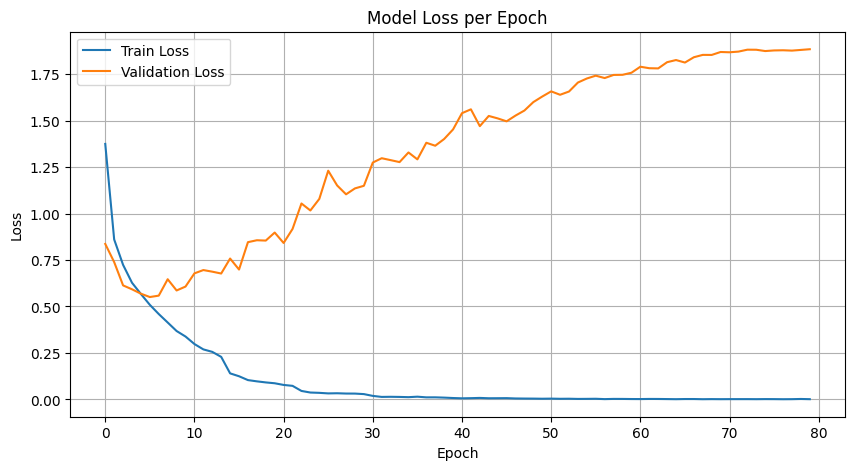

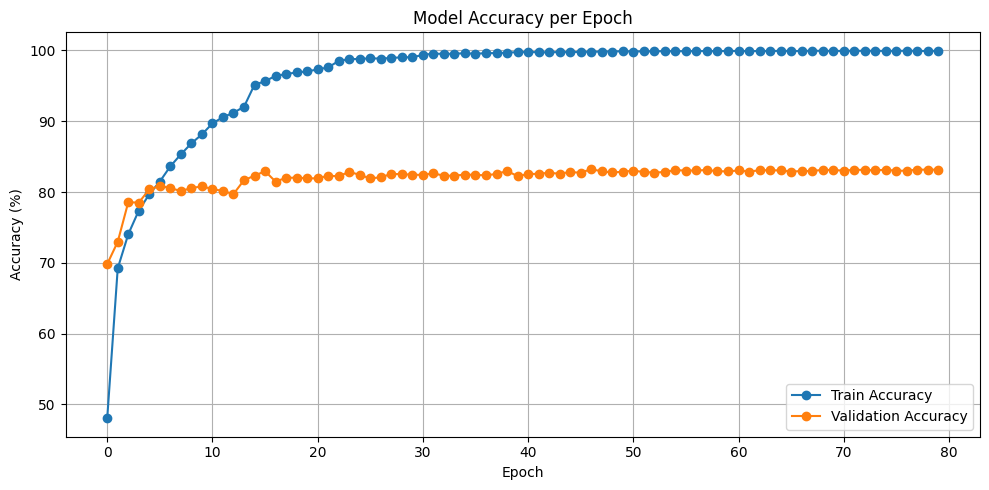

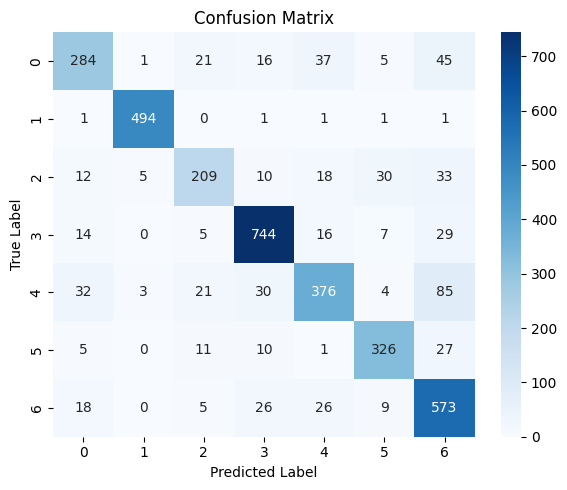


Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.69      0.73       409
           1       0.98      0.99      0.99       499
           2       0.77      0.66      0.71       317
           3       0.89      0.91      0.90       815
           4       0.79      0.68      0.73       551
           5       0.85      0.86      0.86       380
           6       0.72      0.87      0.79       657

    accuracy                           0.83      3628
   macro avg       0.83      0.81      0.82      3628
weighted avg       0.83      0.83      0.83      3628



In [10]:
# Config
root_dir = "/kaggle/input/dr-fatma-mazen/FER+"
batch_size = 64
num_classes = 8
num_epochs = 80
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_path = "/kaggle/working/best_emotion_model.pth"

# Data setup
data_module = FERPlusImageFolderDataModule(root_dir, batch_size)
data_module.setup()

train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()



model = EmotionDetectorVGGFace(num_classes=num_classes)


original_train_dataset = data_module.train_dataset

history = train_model(model, train_loader, val_loader, num_epochs, device, save_path,
                      lr=0.0001, train_dataset=original_train_dataset)



original_test_dataset = data_module.test_dataset
test_loss, test_acc, precision, recall, f1, all_preds, all_labels = test_model(
    model, test_loader, device, test_dataset=original_test_dataset
)


plot_loss_curve(history['train_loss'], history['val_loss'])
plot_accuracy_curve(history['train_acc'], history['val_acc'])

class_names = data_module.train_dataset.classes
plot_confusion_matrix(all_labels, all_preds, class_names)
torch.save(model, "/kaggle/working/emotion_model_full.pt")
